**Predict the probability that an online transaction is fraudulent (denoted by the binary target isFraud)**

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
import pickle

from catboost import CatBoostClassifier

C:\Users\jvine\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jvine\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jvine\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jvine\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jvine\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 19

# Import data

In [2]:
train_transaction = pd.read_csv('Data/train_transaction.csv')
train_identity = pd.read_csv('Data/train_identity.csv')
train_transaction.shape, train_identity.shape

((590540, 394), (144233, 41))

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

In [4]:
train_transaction.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
train_identity.head(2)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


Transaction Table:
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features:
    - ProductCD
    - card1 - card6
    - addr1, addr2
    - Pemaildomain Remaildomain
    - M1 - M9

Identity Table:
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [6]:
set(train_identity.TransactionID.unique()) - set(train_transaction.TransactionID.unique())

set()

Every ID in the identity dataframe is in the transaction df, but not the other way round

# Basic statistics

## transaction df

In [6]:
# train_transaction.describe()

In [7]:
# sns.countplot(train_transaction.isFraud);

The dataset is unbalanced (around 3.5% of labels = 1) and it will be taken into account. Because of that, my **baseline model will be predicting always 0**, ending up with around 96.5% accuracy.

In [8]:
# train_transaction.info()

In [9]:
# plt.figure(figsize=(16,16))
# sns.heatmap(train_transaction.corr())

## identity df

In [10]:
# train_identity.describe()

In [11]:
# train_identity.info()

# Merge dataframes

In [3]:
train_df = train_transaction.merge(train_identity, left_on='TransactionID', right_on='TransactionID', how='outer')
train_df.shape

(590540, 434)

In [8]:
train_df.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [4]:
del train_transaction; del train_identity

# Variables intuitions

In [15]:
# train_df.isna().sum() / train_df.shape[0]

There are a lot of variables with more than 90% of null values

In [16]:
# train_df[train_df.isFraud == 1].head(20)

In [17]:
# train_df.columns

In [18]:
# train_df.card4.value_counts()

In [19]:
# sns.countplot(train_df.card4, hue=train_df.isFraud)

In [20]:
# sns.countplot(train_df.ProductCD, hue=train_df.isFraud)

In [21]:
# sns.countplot(train_df.M4, hue=train_df.isFraud)

In [22]:
# sns.countplot(train_df.DeviceType, hue=train_df.isFraud)

# Split into train and test sets

In [5]:
X = train_df.drop(columns=['isFraud', 'TransactionID'])
y = train_df.isFraud

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train.head(2)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
216944,5069957,440.95,W,13809,583.0,150.0,visa,226.0,credit,204.0,87.0,852.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,39.0,T,F,F,NaN,NaN,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,440.950012,440.950012,440.950012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.950012,440.950012,440.950012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
558411,14773564,460.00,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,10.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,

In [8]:
del train_df; del X; del y

# Build first quick and simple model

## Delete columns with more than 75% null values

In [27]:
cols_to_delete = (X_train.isna().sum() / X_train.shape[0])[(X_train.isna().sum() / X_train.shape[0])>0.75].index
X_train.drop(columns=cols_to_delete, inplace=True)
X_test.drop(columns=cols_to_delete, inplace=True)
X_train.shape, X_test.shape

((472432, 224), (118108, 224))

## Delete categorical features

In [28]:
cols_to_delete = X_train.dtypes[X_train.dtypes==object].index
X_train.drop(columns=cols_to_delete, inplace=True)
X_test.drop(columns=cols_to_delete, inplace=True)
X_train.shape, X_test.shape

((472432, 211), (118108, 211))

## Fill null values

In [29]:
X_train.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)
X_train.shape, X_test.shape

((472432, 211), (118108, 211))

## Standardize values

In [30]:
# scaler = StandardScaler()
# std_X_train = scaler.fit_transform(X_train)
# std_X_test = scaler.transform(X_test)

## Reduce number of variables

In [31]:
# pca = PCA(.95)
# pca.fit(std_X_train)

In [32]:
# reduced_X_train = pca.transform(std_X_train)
# reduced_X_test = pca.transform(std_X_test)

**Plot explained variance**

In [33]:
# plt.figure(figsize=(16,10))
# plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_/sum(pca.explained_variance_))
# plt.plot(range(1,len(pca.explained_variance_ )+1), np.cumsum(pca.explained_variance_)/sum(pca.explained_variance_), 
#          c='red', label="Cumulative Explained Variance")
# plt.plot(range(1,len(pca.explained_variance_ )+1), [0.95 for i in range(1,len(pca.explained_variance_ )+1)], '--g', label="Cumulative Explained Variance")
# plt.plot([62 for i in np.arange(0,1.1,0.1)], np.arange(0,1.1,0.1), '--g')
# plt.ylabel('Explained variance')
# plt.xlabel('Components')
# plt.legend(loc='upper left')
# plt.show()

## Modeling

In [34]:
model = Pipeline(steps=[('std_scaler', StandardScaler()),
                        ('pca', PCA(.95)),
                        ('xgb', XGBClassifier(max_depth=7, eval_metric='auc'))])
_ = model.fit(X_train, y_train.loc[X_train.index])

KeyboardInterrupt: 

In [ ]:
filename = 'Data/xgb_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
y_pred = model.predict_proba(X_test)[:,1]

In [ ]:
model.score(X_test, y_test.loc[X_test.index])

In [ ]:
roc_auc_score(y_test.loc[X_test.index], y_pred)

In [ ]:
plot_roc_curve(model, X_test, y_test.loc[X_test.index])
plt.plot([0,1],[0,1],'--r')
plt.show();

## Predict submition set

### Import data

In [ ]:
test_transaction = pd.read_csv('Data/test_transaction.csv')
test_identity = pd.read_csv('Data/test_identity.csv')
test_transaction.shape, test_identity.shape

### Merge dataframes

In [ ]:
test_df = test_transaction.merge(test_identity, left_on='TransactionID', right_on='TransactionID', how='outer')
test_df.shape

In [ ]:
# whos

In [ ]:
del test_transaction; del test_identity;

### Use same columns as train set

In [ ]:
cols_to_keep = ['TransactionID','TransactionDT','TransactionAmt','card1','card2','card3','card5','addr1','addr2','dist1',
                'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D5',
                'D10','D11','D15','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16',
                'V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31','V32','V33',
                'V34','V35','V36','V37','V38','V39','V40','V41','V42','V43','V44','V45','V46','V47','V48','V49','V50',
                'V51','V52','V53','V54','V55','V56','V57','V58','V59','V60','V61','V62','V63','V64','V65','V66','V67',
                'V68','V69','V70','V71','V72','V73','V74','V75','V76','V77','V78','V79','V80','V81','V82','V83','V84',
                'V85','V86','V87','V88','V89','V90','V91','V92','V93','V94','V95','V96','V97','V98','V99','V100','V101',
                'V102','V103','V104','V105','V106','V107','V108','V109','V110','V111','V112','V113','V114','V115','V116',
                'V117','V118','V119','V120','V121','V122','V123','V124','V125','V126','V127','V128','V129','V130','V131',
                'V132','V133','V134','V135','V136','V137','V279','V280','V281','V282','V283','V284','V285','V286','V287',
                'V288','V289','V290','V291','V292','V293','V294','V295','V296','V297','V298','V299','V300','V301','V302',
                'V303','V304','V305','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317',
                'V318','V319','V320','V321']

In [ ]:
test_df = test_df[cols_to_keep]
test_df.shape

### Fill null values

In [ ]:
test_df.fillna(-1, inplace=True)

### Modeling

In [ ]:
filename = 'Data/xgb_model.sav'
model = pickle.load(open(filename, 'rb'))

In [ ]:
test_df['isFraud'] = model.predict_proba(test_df.drop(columns='TransactionID'))[:,1]

In [ ]:
test_df[['TransactionID','isFraud']].head(2)

In [ ]:
test_df[['TransactionID','isFraud']].to_csv('Data/submission.csv', index=False)

# Look at the columns with more than 75% null values

In [44]:
null_cols = (train_df.isna().sum() / train_df.shape[0])[(train_df.isna().sum() / train_df.shape[0])>0.75].index
len(null_cols)

208

In [45]:
null_cols[:9]

Index(['dist2', 'R_emaildomain', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14'], dtype='object')

"R_emaildomain" doesn't seem relevant

In [46]:
null_cols[9:168]

Index(['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=159)

In [47]:
null_cols[168:]

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [48]:
train_df[null_cols[-2]].value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

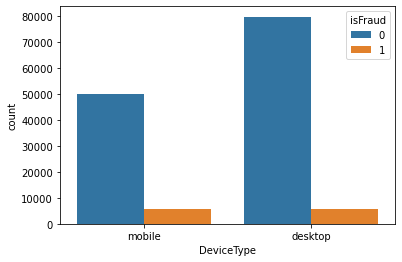

In [49]:
sns.countplot(train_df.DeviceType, hue=train_df.isFraud);

In [50]:
train_df[null_cols[-1]].value_counts()

Windows                                        47722
iOS Device                                     19782
MacOS                                          12573
Trident/7.0                                     7440
rv:11.0                                         1901
rv:57.0                                          962
SM-J700M Build/MMB29K                            549
SM-G610M Build/MMB29K                            461
SM-G531H Build/LMY48B                            410
rv:59.0                                          362
SM-G935F Build/NRD90M                            334
SM-G955U Build/NRD90M                            328
SM-G532M Build/MMB29T                            316
ALE-L23 Build/HuaweiALE-L23                      312
SM-G950U Build/NRD90M                            290
SM-G930V Build/NRD90M                            274
rv:58.0                                          269
rv:52.0                                          256
SAMSUNG                                       

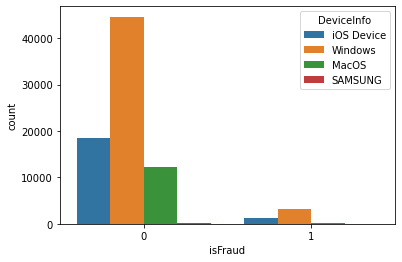

In [51]:
sns.countplot(train_df[train_df.DeviceInfo.isin(['Windows','iOS Device','MacOS','SAMSUNG'])].isFraud, hue=train_df[train_df.DeviceInfo.isin(['Windows','iOS Device','MacOS','SAMSUNG'])].DeviceInfo);

In [52]:
train_df.R_emaildomain.value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
prodigy.net.mx        207
ymail.com             207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [53]:
train_df.P_emaildomain.value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
roadrunner.com         305
hotmail.es             305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [11]:
train_df.groupby(by='R_emaildomain').agg(['mean','count']).isFraud

,mean,count
R_emaildomain,,
aim.com,0.027778,36
anonymous.com,0.029130,20529
aol.com,0.034855,3701
att.net,0.000000,430
bellsouth.net,0.004739,422
cableone.net,0.000000,27
centurylink.net,0.000000,12
cfl.rr.com,0.000000,37
charter.net,0.039370,127


In [12]:
train_df.groupby(by='P_emaildomain').agg(['mean','count']).isFraud

,mean,count
P_emaildomain,,
aim.com,0.126984,315
anonymous.com,0.023217,36998
aol.com,0.021811,28289
att.net,0.007439,4033
bellsouth.net,0.027763,1909
cableone.net,0.018868,159
centurylink.net,0.000000,205
cfl.rr.com,0.000000,172
charter.net,0.030637,816


# Evaluate identity df by itself

In [20]:
train_identity.shape

(144233, 41)

In [22]:
train_identity.isna().sum()

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

In [21]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [25]:
train_identity[['id_01','id_02','id_05','id_06','id_11','id_12','id_13','id_14','id_15','id_16','id_17','id_19',
                'id_20','id_28','id_29','id_35','id_36','id_37','id_38']].head()

,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_35,id_36,id_37,id_38
0,0.0,70787.0,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,542.0,144.0,New,NotFound,T,F,T,T
1,-5.0,98945.0,0.0,-5.0,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,621.0,500.0,New,NotFound,T,F,F,T
2,-5.0,191631.0,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,410.0,142.0,Found,Found,F,F,T,T
3,-5.0,221832.0,0.0,-6.0,100.0,NotFound,52.0,NaN,New,NotFound,225.0,176.0,507.0,New,NotFound,F,F,T,T
4,0.0,7460.0,1.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,529.0,575.0,Found,Found,T,F,T,T


In [35]:
train_identity.id_17.min(),train_identity.id_17.max(),train_identity.id_17.mean(),train_identity.id_17.nunique()

(100.0, 229.0, 189.45137727902187, 104)

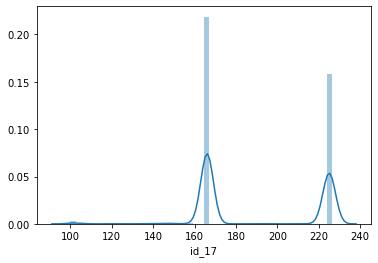

In [36]:
sns.distplot(train_identity.id_17)

# Catboost model

## Preprocess data

**Delete unnecessary columns**

In [14]:
cols_to_delete = (X_train.isna().sum() / X_train.shape[0])[(X_train.isna().sum() / X_train.shape[0])>0.75].index.drop(['R_emaildomain','DeviceType','DeviceInfo'])
X_train.drop(columns=cols_to_delete, inplace=True)
X_test.drop(columns=cols_to_delete, inplace=True)
X_train.shape, X_test.shape

((472432, 227), (118108, 227))

In [17]:
cols_to_delete = X_train.dtypes[X_train.dtypes==object].index.drop(['P_emaildomain','R_emaildomain','DeviceType','DeviceInfo'])
X_train.drop(columns=cols_to_delete, inplace=True)
X_test.drop(columns=cols_to_delete, inplace=True)
X_train.shape, X_test.shape

((472432, 215), (118108, 215))

**Fill null values**

In [27]:
X_train.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)
X_train.fillna('Unknown', inplace=True)
X_test.fillna('Unknown', inplace=True)
X_train.shape, X_test.shape

((472432, 215), (118108, 215))

## Model

**Train model**

In [29]:
categorical_features = ['P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']

In [78]:
model = CatBoostClassifier(max_depth=12,eval_metric='AUC',loss_function='Logloss',one_hot_max_size=20,iterations=100,
                           task_type="GPU",devices='0:1')
_ = model.fit(X_train, y_train.loc[X_train.index], cat_features=categorical_features)

Learning rate set to 0.189097
0:	learn: 0.7060647	total: 601ms	remaining: 59.5s
1:	learn: 0.8239950	total: 1.28s	remaining: 1m 2s
2:	learn: 0.8427168	total: 1.92s	remaining: 1m 1s
3:	learn: 0.8574778	total: 2.56s	remaining: 1m 1s
4:	learn: 0.8619472	total: 3.18s	remaining: 1m
5:	learn: 0.8692401	total: 3.82s	remaining: 59.9s
6:	learn: 0.8715245	total: 4.47s	remaining: 59.4s
7:	learn: 0.8758767	total: 5.17s	remaining: 59.4s
8:	learn: 0.8791553	total: 5.86s	remaining: 59.2s
9:	learn: 0.8876041	total: 6.54s	remaining: 58.8s
10:	learn: 0.8912252	total: 7.24s	remaining: 58.6s
11:	learn: 0.8939065	total: 7.93s	remaining: 58.2s
12:	learn: 0.8981863	total: 8.66s	remaining: 58s
13:	learn: 0.9011925	total: 9.44s	remaining: 58s
14:	learn: 0.9026287	total: 10.1s	remaining: 57.3s
15:	learn: 0.9043438	total: 10.8s	remaining: 56.9s
16:	learn: 0.9072191	total: 11.5s	remaining: 56.4s
17:	learn: 0.9094403	total: 12.2s	remaining: 55.7s
18:	learn: 0.9115648	total: 13s	remaining: 55.4s
19:	learn: 0.9136738

In [ ]:
filename = 'Data/cbc_model.sav'
pickle.dump(model, open(filename, 'wb'))

**Evaluate model**

In [79]:
y_pred = model.predict_proba(X_test)[:,1]

In [80]:
model.score(X_test, y_test.loc[X_test.index])

0.9817539878755038

In [81]:
roc_auc_score(y_test.loc[X_test.index], y_pred)

0.9382413196118966

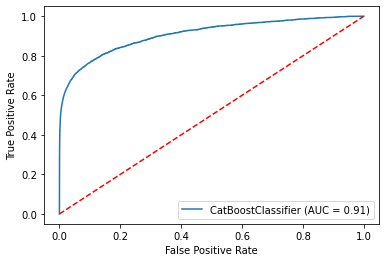

In [45]:
plot_roc_curve(model, X_test, y_test.loc[X_test.index])
plt.plot([0,1],[0,1],'--r')
plt.show();

In [82]:
len(X_train.columns)

215

In [88]:
X_train.columns[np.argsort(model.feature_importances_)][-23:]

Index(['DeviceType', 'C5', 'V312', 'V317', 'D1', 'D2', 'D4', 'D15', 'C14',
       'C6', 'C2', 'DeviceInfo', 'C11', 'R_emaildomain', 'P_emaildomain',
       'TransactionAmt', 'addr1', 'C13', 'card5', 'C1', 'card1', 'card2',
       'TransactionDT'],
      dtype='object')

**The 4 categorical features I selected ended up being between the 23 most important features. 3 of them within the most important 12.**